In [17]:
import boto3
from dotenv import load_dotenv
import os.path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pycaret.regression import setup, predict_model, compare_models, load_model, create_model, save_model, plot_model, finalize_model # type: ignore

In [18]:
MODELS_PATH = 'halfmarathon/models/'
DATA_PATH = 'halfmarathon/data/'
BUCKET_NAME = "nowy"

load_dotenv()

True

In [19]:
def convert_time_to_seconds(time):
    if pd.isnull(time) or time in ['DNS', 'DNF']:
        return None
    time = time.split(':')
    return int(time[0]) * 3600 + int(time[1]) * 60 + int(time[2])

def convert_seconds_to_time(seconds):
    seconds = int(seconds)
    min, sec = divmod(seconds, 60)
    hrs, min = divmod(min, 60)

    return f'{hrs:02d}:{min:02d}:{sec:02d}'

def download_models():
    models = []

    try:
        model_list = get_file_list(prefix=MODELS_PATH)
                
        for item in model_list:
            model = item['Key']
            if str(model).endswith('.pkl'):
                models.append(model)
    except:
        return None

    return models

def get_digital_ocean_client():
    return boto3.client('s3',)

def get_file_list(prefix):
    s3 = get_digital_ocean_client()
    response = s3.list_objects_v2(Bucket = BUCKET_NAME, Prefix = prefix)
    return response['Contents']

def download_file(file_full_name):
    s3 = get_digital_ocean_client()
    base_name = os.path.basename(file_full_name)
    s3.download_file(BUCKET_NAME, file_full_name, base_name)
    return base_name

def upload_file(file_name, prefix):
    s3 = get_digital_ocean_client()
    s3.upload_file(file_name, BUCKET_NAME, prefix + file_name)

### Pobierz listę plików csv

In [20]:
csv_list = get_file_list(DATA_PATH)

### Wczytaj dane do Data Frame

In [21]:
csv_names = []

for item in csv_list:
    f = item['Key']
    if str(f).endswith('.csv'):
        csv_names.append(f)

file1 = download_file(csv_names[0]) 
file2 = download_file(csv_names[1]) 

m2023_df = pd.read_csv(file1, sep=';')    
m2024_df = pd.read_csv(file2, sep=';')

In [22]:
m2023_df['Czas'] = m2023_df['Czas'].apply(convert_time_to_seconds)
m2023_df['5 km Czas'] = m2023_df['5 km Czas'].apply(convert_time_to_seconds)

m2024_df['Czas'] = m2024_df['Czas'].apply(convert_time_to_seconds)
m2024_df['5 km Czas'] = m2024_df['5 km Czas'].apply(convert_time_to_seconds)

m2023_df = m2023_df[['Miejsce', 'Nazwisko','Płeć', 'Kategoria wiekowa', '5 km Czas', 'Czas']]
m2024_df = m2024_df[['Miejsce', 'Nazwisko','Płeć', 'Kategoria wiekowa', '5 km Czas', 'Czas']]

In [23]:
m2023_df.isnull().sum()
m2023_df.sort_values(by='Miejsce', inplace=True)
m2023_df['5 km Czas'].fillna(method='bfill', inplace=True)

m2023_df.dropna(inplace=True)

# m2023_df.describe()

In [24]:
m2024_df.isnull().sum()
m2024_df.sort_values(by='Miejsce', inplace=True)
m2024_df['5 km Czas'].fillna(method='bfill', inplace=True)

m2024_df.dropna(inplace=True)


# m2024_df[(m2024_df['5 km Czas'].isnull()) & (m2024_df['Czas'].notnull())]

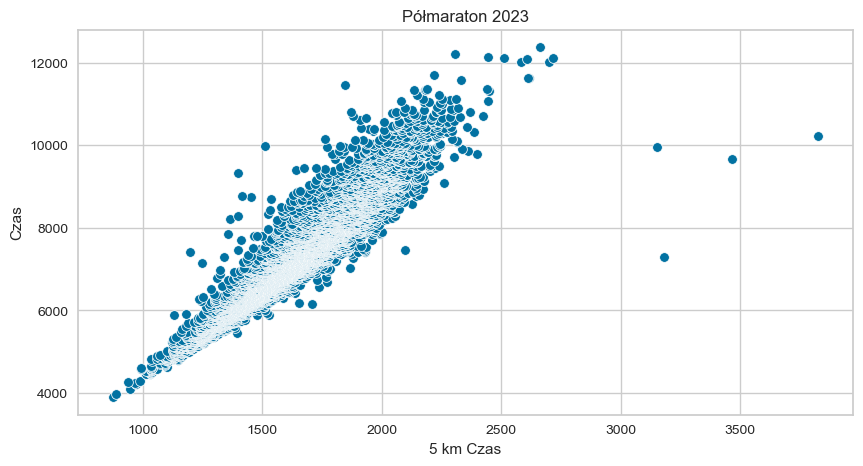

In [25]:
fig = plt.figure(figsize=(10,5))
plt.title("Półmaraton 2023")
sns.scatterplot(data=m2023_df, x="5 km Czas", y='Czas');

In [26]:
# # Odrzuć odstające dane

# Q1 = m2023_df["5 km Czas"].quantile(0.25)
# Q3 = m2023_df["5 km Czas"].quantile(0.75)
# IQR = Q3 - Q1

# lower_bound = Q1 - 1.5 * IQR
# upper_bound = Q3 + 1.5 * IQR

# m2023_df = m2023_df[~((m2023_df["5 km Czas"] < lower_bound) | (m2023_df["5 km Czas"] > upper_bound))]


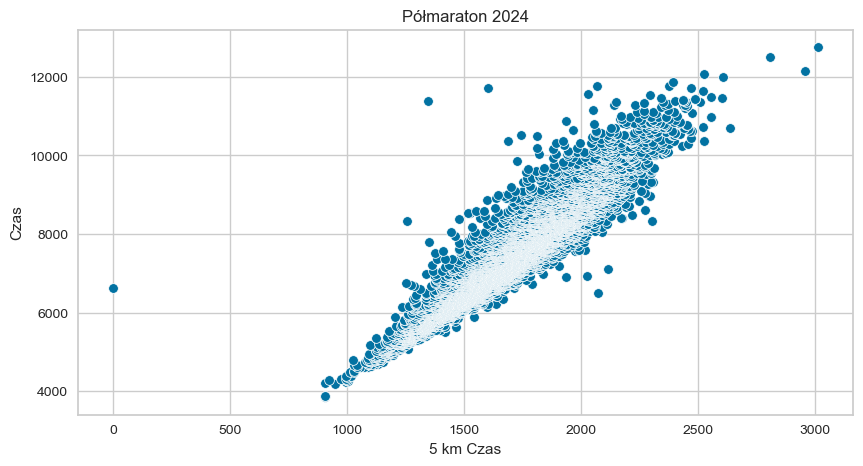

In [27]:
fig = plt.figure(figsize=(10,5))
plt.title("Półmaraton 2024")
sns.scatterplot(data=m2024_df, x="5 km Czas", y='Czas');

### Uratujemy rekord gdzie '5 km Czas' == 0

In [29]:
idx = m2024_df[m2024_df['5 km Czas'] == 0].index[0]
m2024_df.loc[idx]
m2024_df.loc[idx, '5 km Czas'] = None
m2024_df['5 km Czas'].fillna(method='bfill', inplace=True)
m2024_df.loc[idx]

Miejsce                     2630.0
Nazwisko             WOJCIECHOWSKI
Płeć                             M
Kategoria wiekowa              M30
5 km Czas                   1548.0
Czas                        6617.0
Name: 2629, dtype: object

### Połącz dane obu półmaratonów

In [30]:
marathon_df = pd.concat([m2023_df, m2024_df], ignore_index=True)
marathon_df = marathon_df[['Płeć', 'Kategoria wiekowa', '5 km Czas', 'Czas']]
marathon_df.columns = ['sex', 'age_category', '5time', 'time']
marathon_df.isna().any()

sex             False
age_category    False
5time           False
time            False
dtype: bool

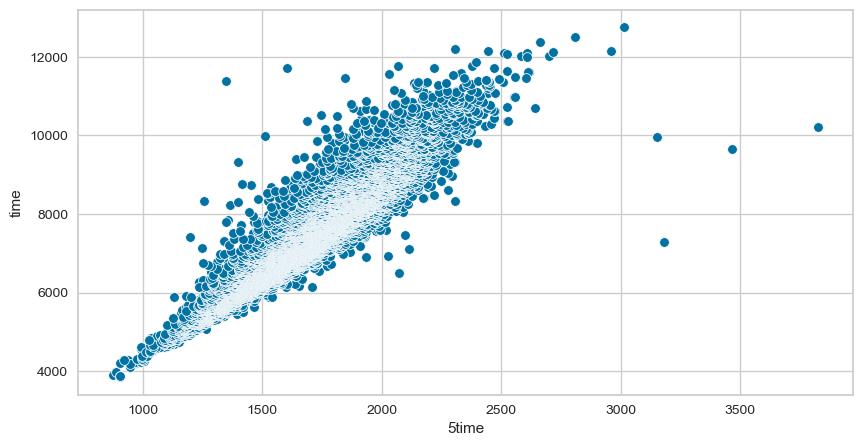

In [31]:
fig = plt.figure(figsize=(10,5))
sns.scatterplot(data=marathon_df, x="5time", y='time');

In [32]:
# Odrzuć odstające dane

Q1 = marathon_df["5time"].quantile(0.25)
Q3 = marathon_df["5time"].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

marathon_df = marathon_df[~((marathon_df["5time"] < lower_bound) | (marathon_df["5time"] > upper_bound))]

In [33]:
# Zaczynamy...

exp = setup(data=marathon_df, target='time', session_id=123, index=False)

,Description,Value
0,Session id,123
1,Target,time
2,Target type,Regression
3,Original data shape,"(18294, 4)"
4,Transformed data shape,"(18294, 16)"
5,Transformed train set shape,"(12805, 16)"
6,Transformed test set shape,"(5489, 16)"
7,Numeric features,1
8,Categorical features,2
9,Preprocess,True


In [34]:
model_mapping = 	{
		'GradientBoostingRegressor':'gbr', 
		'CatBoostRegressor' : 'catboost', 
		'LGBMRegressor' : 'lightgbm', 
		'ElasticNet' : 'en', 
		'LassoLars' : 'llar', 
		'OrthogonalMatchingPursuit' : 'omp', 
		'BayesianRidge' : 'br', 
		'Lasso': 'lasso', 
		'LinearRegression' : 'lr', 
		'Ridge' : 'ridge',
        'LassoLars' : 'llar',
	}

In [35]:
# Pierwsze 3 modele
N_SELECT = 3
best_models = exp.compare_models(n_select=N_SELECT)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,13:20:02
Status,. . . . . . . . . . . . . . . . . .,Loading Estimator
Estimator,. . . . . . . . . . . . . . . . . .,Linear Regression


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,302.9940,175580.7542,418.7337,0.8752,0.0529,0.0396,0.2840
lr,Linear Regression,304.3760,175965.0620,419.2051,0.8750,0.0530,0.0397,0.9000
lasso,Lasso Regression,304.3649,175913.1988,419.1468,0.8750,0.0530,0.0397,0.0450
ridge,Ridge Regression,304.3635,175956.8826,419.1953,0.8750,0.0530,0.0397,0.0410
llar,Lasso Least Angle Regression,304.3649,175913.2037,419.1469,0.8750,0.0530,0.0397,0.0650
en,Elastic Net,304.4066,175999.6158,419.2503,0.8749,0.0530,0.0397,0.0430
omp,Orthogonal Matching Pursuit,304.4056,176020.5171,419.2751,0.8749,0.0530,0.0397,0.0450
br,Bayesian Ridge,304.4297,176018.2867,419.2721,0.8749,0.0530,0.0397,0.0500
lightgbm,Light Gradient Boosting Machine,305.8555,179591.4215,423.4671,0.8724,0.0535,0.0399,0.1830
huber,Huber Regressor,300.7166,180698.0081,424.7769,0.8716,0.0533,0.0389,0.1000


In [36]:
model_names = [model.__class__.__name__ for model in best_models]
print(model_names)

['GradientBoostingRegressor', 'LinearRegression', 'Lasso']


In [37]:
# Mapuj wybrane modele
model_map_df = pd.DataFrame(model_names, columns=['name'])
model_map_df['abbrev'] = model_map_df['name'].map(model_mapping)
model_map_df['model'] = None
print(model_map_df)

                        name abbrev model
0  GradientBoostingRegressor    gbr  None
1           LinearRegression     lr  None
2                      Lasso  lasso  None


In [38]:
# Trzy pierwsze modele są zapisywane lokalnie i w Digital Ocean Spaces
# Indeksy w nazwach modeli wskazują, który jest 1, 2 a który trzeci

for idx in range(N_SELECT):
    print(model_map_df['abbrev'][idx])
    current_model = create_model(model_map_df['abbrev'][idx], verbose=False)
    f_model = finalize_model(current_model)
    save_model(f_model, f"{model_map_df['abbrev'][idx]}_{idx}")
    upload_file(f"{model_map_df['abbrev'][idx]}_{idx}.pkl", MODELS_PATH)
    # plot_model(f_model, 'feature')

gbr
Transformation Pipeline and Model Successfully Saved
lr
Transformation Pipeline and Model Successfully Saved
lasso
Transformation Pipeline and Model Successfully Saved


In [39]:
# Dane testowe
predict_run = pd.DataFrame([
    {
        'sex' : 'M',
        'age_category' : 'M30',
        '5time' : 1095
    }
])

Transformation Pipeline and Model Successfully Loaded


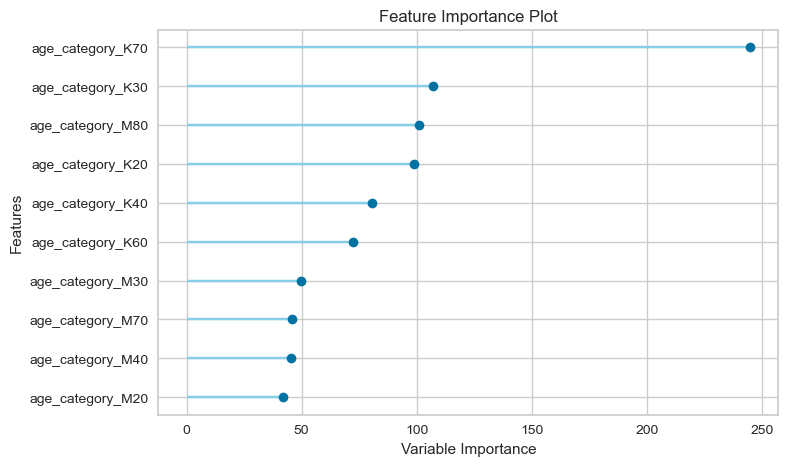

01:18:25, 4705s


In [31]:
loaded_model = load_model('model_lr_1')
plot_model(loaded_model, 'feature')
predict = predict_model(loaded_model, data = predict_run)
print(f"{convert_seconds_to_time(predict['prediction_label'])}, {int(predict['prediction_label'])}s")

In [29]:
predict

,sex,age_category,5time,prediction_label
0,M,M30,1095,4813.656151


In [28]:
marathon_df[marathon_df['5time'] == 1095].head()

,sex,age_category,5time,time
33,M,M20,1095.0,4735.0


In [ ]:
convert_seconds_to_time(4735)